Import des librairies

Ce notebook Jupyter présente une façon de mettre en oeuvre la librairie SALIB [1] pour réaliser une analyse de sensibilité d'un modèle à ses variables d'entrée. Le cas du modèle de confort de Gagge est proposé (librairie Pythermalcomfort [2]). Le notebook présente le calcul des indices de Sobol du premier ordre selon la méthode RBD-FAST (Random Balance Design Fourier Amplitude Sensitivity Test) [3,4] 

[1] J. Herman and W. Usher, ‘SALib: An open-source Python library for Sensitivity Analysis’, Journal of Open Source Software, vol. 2, no. 9, p. 97, Jan. 2017, doi: 10.21105/joss.00097.
[2] F. Tartarini and S. Schiavon, ‘pythermalcomfort: A Python package for thermal comfort research’, SoftwareX, vol. 12, p. 100578, Jul. 2020, doi: 10.1016/j.softx.2020.100578.
[3] S. Tarantola, D. Gatelli, and T. A. Mara, ‘Random balance designs for the estimation of first order global sensitivity indices’, Reliability Engineering & System Safety, vol. 91, no. 6, pp. 717–727, Jun. 2006, doi: 10.1016/j.ress.2005.06.003.
[4] J. Goffart and M. Woloszyn, ‘EASI RBD-FAST: An efficient method of global sensitivity analysis for present and future challenges in building performance simulation’, Journal of Building Engineering, vol. 43, p. 103129, Nov. 2021, doi: 10.1016/j.jobe.2021.103129.



ETAPE 1 : IMPORTATION DES LIBRAIRIES

La première étape vise à importer les librairies nécessaires pour
* les manipulations classiques dans python (pandas, numpy,seaborn, matplotlib),
* le modèle à deux noeud de Gagge, via la librairie Pythermalcomfort
* les outils de SALIB pour la méthode RBD-FAST pour l'analyse de sensibilité (S)
Dans SAlib, la construction des classes  est relativement commune à toutes les techniques d'analyse de sensibilité. Il s'agira d'importer la méthode génération des tirages (combinaisons de paramètres) issue de la classe _.sample, la classe _.analyse qui réalisera le calcul des indices de sensiblité et la classe _plotting qui selon la méthode choisie permettra, via matplotlib, de réaliser une représentation graphique des indices. La classe _.plotting n'est pas disponible pour toute les méthodes et nécessitera dans certains cas le développement d'un code spécifique.

In [65]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pythermalcomfort import two_nodes
from SALib.sample import latin
from SALib.analyze import rbd_fast
from SALib.plotting.bar import plot as barplot


ETAPE 2 : DEFINITION DU MODELE A ANALYSER

Ici, nous définissons un modèle générique "model4sa" fonction des entrées dont nous souhaitons connaitre l'influence sur la sortie. Ceci nous permet, sans avoir à modifier la suite du code de profiter de la multitude des sorties du modèle à deux noeuds depuis Pythermalcomfort, ou, de changer de modèle pour celui de Fanger par exemple.

In [66]:
def model4sa(tdb,
                tr,
                v,
                rh,
                met,
                clo,
                standard="ASHRAE", limit_inputs=False, round=False):
    
    pythermal=two_nodes(tdb=tdb,
                        tr=tr,
                        v=v,
                        rh=rh,
                        met=met,
                        clo=clo,
                        standard="ASHRAE", limit_inputs=False, round=False)
    
    pts = 0.25 * pythermal['_set'] - 6.03 # calcul de la predicted thermal sensation, non disponible dans la librairie Pythermalcomfort
   
    
    return {"_set": pythermal['_set'],
                    "et":pythermal['et'],
                    "t_core" : pythermal['t_core'],
                    "t_skin" : pythermal['t_skin'],
                    "pmv_gagge" : pythermal['pmv_gagge'],
                    "pmv_set" : pythermal['pmv_set'],
                    'w' : pythermal['w'],
                    'w_max' : pythermal['w_max'],
                    "disc" : pythermal['disc'],
                    "t_sens" : pythermal['t_sens'],
                    'pts' : pts,
                    }

ETAPE 3 : SELECTION DE LA SORTIE A ANALYSER

La lirairie pythermalcomfort offre la possibilité pour le modèle de Gagge de sortir plusieurs indices ou constantes physiologiques. Nous sélectionnons ici la sortie souhaitée sur laquelle nous allons réaliser l'analyse de sensibilité.

In [67]:
model_output_name="_set"
                    # "et",
                    # "t_core",
                    # "t_skin",
                    # "pmv_gagge",
                    # "pmv_set",
                    # 'w',
                    # 'w_max',
                    # "disc",
                    # "t_sens",
                    # 'pts',
                    
                    
                    

ETAPE 4 : DEFINITION DU NOMBRE DE TIRAGES ET DU DOMAINE DE VARIATIONS DES PARAMETRES

Nous définissons ici le nombre de tirages "samples". ce nombre de tirage est le nombre minimum pour lequel l'indice de premier odre converge. Une étude de convergence préalable est nécessaire. Le blog suivant décrit précisement la méthode à employer et propose un code python. Nous ne reproduisons pas ici cette méthode pour des raisons évidendes de temps de calcul durant l'atelier SIMUREX.

[1] A. Hadjimichael, ‘Determining the appropriate number of samples for a sensitivity analysis’, Water Programming: A Collaborative Research Blog. Accessed: Jul. 13, 2023. [Online]. Available: https://waterprogramming.wordpress.com/2020/03/23/determining-the-appropriate-number-of-samples-for-a-sensitivity-analysis/

Enfin, nous défintions le domaine de variation de chacun de nos paramètres dont on souhaite étudier la contribution sur la sortie. Il s'agit ici des variables d'entrée du modèles de Gagge que sont la vitesse, la température d'air, l'humidité relative, la température rayonnante moyenne, le métabolisme, la vêture.


In [68]:
# Nombre de tirages
samples=10000
# Domaine de variation des paramètres / entrées
lower_v = 0.01 
upper_v = 2.2
lower_met = 1.1 #0.65
upper_met = 1.11  #0.26
lower_clo = 0.29
upper_clo = 0.79
lower_tdb = 25.4
upper_tdb = 32.1
lower_tr = 23.1
upper_tr = 31.2
lower_rh = 60
upper_rh = 90

ETAPE 5 : DEFINITION DE L'ANALYSE DE SENSIBILITE

SAlib est construite sur la base d'un dictionnaire "problem" qui défini le domaine de variation des paramètres et leur distribution.

In [69]:

problem = {
    'num_vars': 6, # nombre de paramètres
    'names': [ 'tdb', 'tr', 'v', 'rh', 'met', 'clo'], # paramètres / entrées dans le bon ordre
    'bounds': [
        [lower_tdb, upper_tdb],
        [lower_tr, upper_tr],
        [lower_v, upper_v],
        [lower_rh, upper_rh],
        [lower_met, upper_met],
        [lower_clo, upper_clo]
            ],
    'dist' : ['unif',
              'unif',
              'unif',
              'unif', 
              'unif',
              'unif']    
            
        }

ETAPE 6 : REALISATION DES tirages

On utilisa ici la méthode LHS préconisée pour la méthode RBD-FAST. ._sample prend en général comme argument le nombre de tirage souhaité et le dictionnaire 'problem'. Selon les méthode (Morris, saltellisobol...) il se peut que la méthode sample soit légèrement différente.

In [70]:
# Generate the parameter samples using SALIB RBDfast recommanded method (Latin Hypercube sampling)
sampling = latin.sample(problem, samples)


ETAPE 7 : EVALUATION DU MODELE

Nous évaluons maintenant le modèle pour toutes les combinaisons de tirages réalisées par ._sampling et stockées dans la variable 'sampling'.
Un print et un graphique en violon nous permet de vérifier la sortie et son format.


[array(32.87723545), array(26.78265235), array(28.94697721), array(24.30164361), array(24.12063384), array(25.72721403), array(24.61213675), array(24.7254759), array(21.87674756), array(26.25150361), array(29.71138997), array(33.46724477), array(28.817968), array(27.76542839), array(27.56749775), array(28.41942449), array(24.65297234), array(27.29407411), array(28.74687114), array(21.60129043), array(23.80730764), array(25.6201603), array(25.18531039), array(21.36877824), array(23.51690167), array(20.33991763), array(30.62621766), array(32.39048162), array(28.12955682), array(25.47656669), array(24.73342663), array(33.00687245), array(24.62410269), array(27.68558001), array(25.95924201), array(28.07871965), array(26.48146111), array(25.8323864), array(30.09290674), array(22.54226281), array(25.25671601), array(26.54794411), array(22.85383225), array(27.74595747), array(23.27371691), array(30.80288939), array(24.34167821), array(22.95761641), array(32.61245861), array(27.00201758), arra

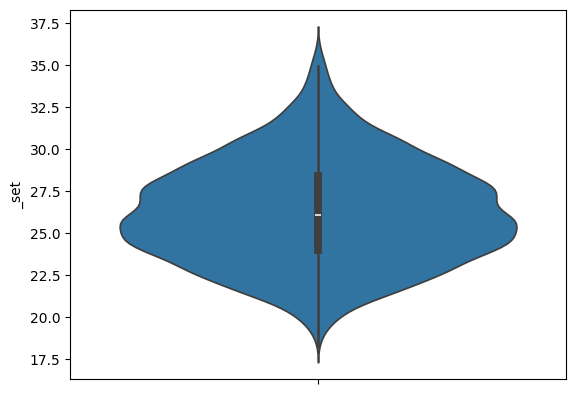

In [71]:
Y = [model4sa(tdb=params[0],
                    tr=params[1],
                    v=params[2],
                    rh=params[3],
                    met=params[4],
                    clo=params[5],
                    standard="ASHRAE", limit_inputs=False, round=False)[model_output_name] for params in sampling
                    ]

print(Y)
Y_df=pd.DataFrame(Y, columns=[model_output_name])
violin=sns.violinplot(data=Y_df, y=model_output_name)

ETAPE 8 : ANALYSE DES INDICES   

Nous arrivons à la dernière étape qui vise à calculer les indices de Sobol du premier ordre via la fonction _.analyse de la classe rbd_fast.
Les indices de Sobol peuvent maintenant être exporté ou représenté sur un histogramme avec leur intervalle de confiance.

         S1   S1_conf names
0  0.411170  0.017943   tdb
1  0.089684  0.012057    tr
2  0.212038  0.021700     v
3  0.049649  0.010259    rh
4 -0.000015  0.002895   met
5  0.205089  0.019066   clo


[Text(0, 0, 'tdb'),
 Text(1, 0, 'tr'),
 Text(2, 0, 'v'),
 Text(3, 0, 'rh'),
 Text(4, 0, 'met'),
 Text(5, 0, 'clo')]

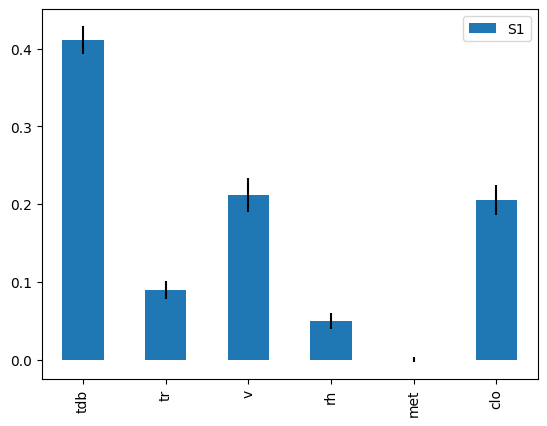

In [72]:
Si = rbd_fast.analyze(problem, sampling, np.asarray(Y), print_to_console=False)

Si_df=pd.DataFrame(Si)
print(Si_df)
names=Si['names']
ax=barplot(Si_df)
ax.set_xticks(range(len(names)))
ax.set_xticklabels(names)